In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline
import seaborn as sns

import re
from tqdm import tqdm
from tqdm import tnrange
from tqdm import tqdm_notebook
from wordcloud import WordCloud

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.feature_extraction import stop_words as sklearn_stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
stemmer = nltk.stem.porter.PorterStemmer()

from pymongo import MongoClient
from bson import json_util

### JSON-Mongo Stuff

In [2]:
# json_address = 'https://www.kaggle.com/jayrav13/american-presidency-project/downloads/presidency.json/1'

In [3]:
# conn = MongoClient()

In [4]:
# conn.database_names()

In [5]:
# db = conn['president']

In [6]:
# data = json_util.dumps(json_file)

### Presidents List

In [7]:
pres_list = pd.read_csv('https://gist.githubusercontent.com/namuol/2657233/raw/74135b2637e624848c163759be9cd14ae33f5153/presidents.csv')

### JSON-Pandas Stuff

In [8]:
json_file = '/home/cneiderer/Downloads/presidency.json'

In [9]:
# Load presidential json data into df
pres_df = pd.read_json(json_file)
# Convert from wide to long format
pres_df = pres_df.T
# Subset data on oral and written speeches
pres_df = pres_df[['Oral', 'Written']]

In [10]:
# Transform into more usable format
df = pd.DataFrame()
for idx in tnrange(len(pres_df.index)):
    pres = pres_df.index[idx]
    pres_data = pres_df.loc[pres]
    
    speech_type = ['Oral', 'Written']
    for jdx in tnrange(len(speech_type)):
        tmp_df = pd.DataFrame.from_dict(pres_df.loc[pres][speech_type[jdx]])
        tmp_df.insert(0, 'President', pres)
        tmp_df.insert(1, 'Type', speech_type[jdx])
        try:
            tmp_df.document_date = pd.to_datetime(tmp_df.document_date)
        except:
            tmp_df.document_data = pd.to_datetime('20500101')
        df = pd.concat([df, tmp_df], axis=0)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58595 entries, 0 to 48
Data columns (total 8 columns):
President        58595 non-null object
Type             58595 non-null object
category         58595 non-null object
content          58595 non-null object
document_date    58595 non-null datetime64[ns]
pid              58595 non-null float64
subcategory      41464 non-null object
title            58595 non-null object
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 4.0+ MB


### Topic Modeling

In [12]:
corpus = df['content']

In [81]:
len(corpus)

58595

In [83]:
# clean reviews
clean_corpus = []
punctuation = re.compile(r"[!#$%&\'\"()\*\+,-\./:;<=>\?@\[\\\]^_`{\|}~]")
for doc in corpus:
    temp = doc.lower()
    temp = re.sub(r'\n', ' ', temp)
    temp = re.sub(r'united\s+states', ' ', temp)
    temp = re.sub(r'vice\s+president', ' ', temp)
    temp = re.sub(r'americaa', 'america', temp)
    temp = re.sub(r'[^A-Za-z]+', ' ', temp)
    temp = re.sub(punctuation, ' ', temp)
    
#     temp = word_tokenize(temp)
#     lemma = []
#     for word in temp:
#         lemma.append(stemmer.stem(word))
#     temp = ' '.join(clean_corpus[0])
    
    clean_corpus.append(temp)
    
len(clean_corpus)

58595

In [85]:
# Helper Function
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]), '\n')
    print()

In [107]:
# Combine Sklearn and NLTK English stop words
custom_stopwords = ['hereunto', 'whereof', 'nineteen', 'said', 'herewith', 'shall', 'say', 'like',
                    'mr', 'sir', 'dear', 'george', 'bush', 'william', 'thirty', 'lot', 'want', 'let', 
                    'sure', 'way', 'section', 'act', 'answer']
stopwords = sklearn_stopwords.ENGLISH_STOP_WORDS.union(nltk_stopwords.words('english')).union(custom_stopwords)

In [109]:
stopwords

frozenset({'a',
           'about',
           'above',
           'across',
           'act',
           'after',
           'afterwards',
           'again',
           'against',
           'ain',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'aren',
           "aren't",
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
     

In [92]:
n_features = 2500
n_topics = 20
n_top_words = 20

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df=0.02,    
                                   max_df=0.8,
                                   stop_words=stopwords,
                                   token_pattern="\\b[a-z][a-z]+\\b")

tfidf = tfidf_vectorizer.fit_transform(clean_corpus)

In [93]:
tfidf.shape

(58595, 2725)

In [103]:
nmf = NMF(n_components=n_topics, random_state=129, alpha=0.1, l1_ratio=0.2, init='nndsvd')
nmf.fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0:
people thank going laughter know got country think good great years make things come time right america work governor thing 

Topic #1:
order executive order executive section amended sec authority vested authority vested white ordered white house follows virtue virtue authority vested president stat code title house 

Topic #2:
house representatives representatives transmit report secretary house resolution report secretary transmit report secretary state senate th instant state accompanying senate house compliance papers requesting answer 

Topic #3:
day america proclamation president week independence independence america set hand witness set year lord lord witness president proclamation president america year americans hand proclaim set national 

Topic #4:
congress program budget legislation year fiscal million programs federal government fiscal year billion funds act administration public increase appropriations house assistance 

Topic #5:
world nations peace people fr

In [104]:
component_dicts = []

components = nmf.components_.round(5)
for index,values in enumerate(components):
    print("topic {}".format(index))
    temp = list(zip(tfidf_feature_names, components[index]))
    print(sorted(temp, key=lambda x: x[1], reverse=True)[:n_top_words], "\n")
    
    component_dicts.append(dict(sorted(temp, key=lambda x: x[1], reverse=True)[:n_top_words]))

topic 0
[('people', 2.7121499999999998), ('thank', 2.3426100000000001), ('going', 2.3265400000000001), ('laughter', 2.19794), ('know', 2.16581), ('got', 1.7717000000000001), ('country', 1.6004400000000001), ('think', 1.5616399999999999), ('good', 1.42025), ('great', 1.24373), ('years', 1.03206), ('make', 1.00234), ('things', 0.95494000000000001), ('come', 0.89688000000000001), ('time', 0.89666999999999997), ('right', 0.87683999999999995), ('america', 0.86699000000000004), ('work', 0.80669999999999997), ('governor', 0.74063999999999997), ('thing', 0.73907)] 

topic 1
[('order', 3.36022), ('executive order', 2.51796), ('executive', 2.3776199999999998), ('section', 2.0705), ('amended', 1.91486), ('sec', 1.43692), ('authority', 1.2292799999999999), ('vested', 1.2006399999999999), ('authority vested', 1.14829), ('white', 0.95852999999999999), ('ordered', 0.93950999999999996), ('white house', 0.89185000000000003), ('follows', 0.87), ('virtue', 0.86878), ('virtue authority', 0.817010000000000

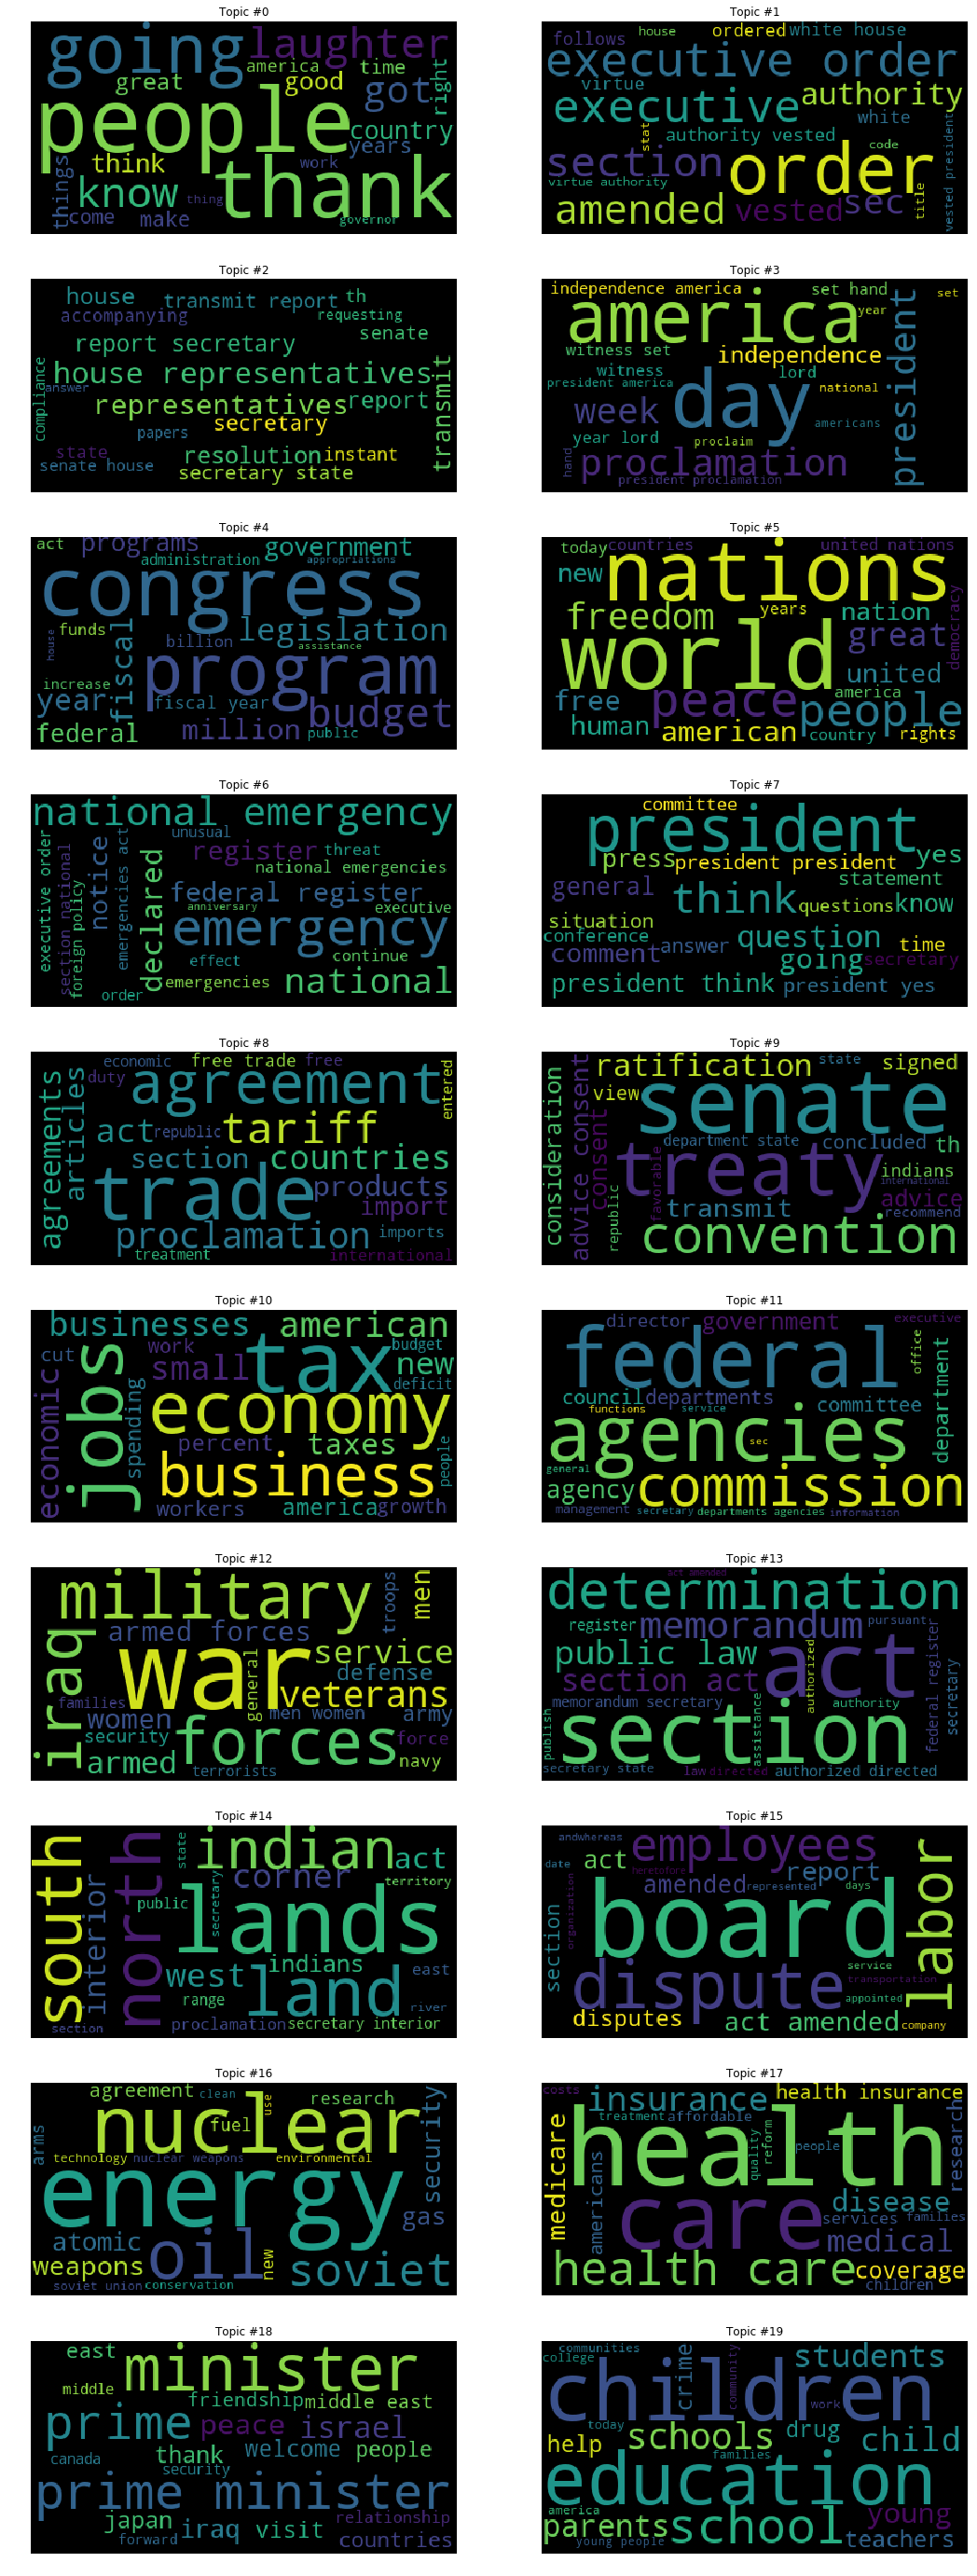

In [105]:
ncol = 2
nrow = int(np.ceil(len(component_dicts) / ncol))

figwidth = ncol * 9
figheight = nrow * 5
fig, axes = plt.subplots(nrow, ncol, figsize=(figwidth, figheight))
ax = axes.flatten()

num_words = 20 # Number of words to include in word cloud
for t in range(len(component_dicts)): 
    plt.sca(ax[t])    
    plt.title("Topic #" + str(t))
    plt.axis("off")    
    plt.imshow(WordCloud().fit_words(component_dicts[t]))

### Figure Number of Clusters

In [110]:
reduced = nmf.fit_transform(tfidf)

In [111]:
reduced.shape

(58595, 20)

In [131]:
# try out a range of cluster sizes to find the one with the best inertia and silhouette scores
inertias = []
silhouettes = []
n_clusters = np.arange(5, 55, 5)
for n in tnrange(len(n_clusters)):
    kmeans = KMeans(n_clusters=n_clusters[n], init="k-means++", random_state=129)
    kmeans.fit(reduced)
    
    inertias.append(kmeans.inertia_)
    
    # only a sample was used to calculate silhouette score because of memory errors
    labels = kmeans.labels_
    silhouettes.append(silhouette_score(reduced, labels, metric='euclidean', sample_size=10000))

A Jupyter Widget

Exception in thread Thread-11:
Traceback (most recent call last):
  File "/home/cneiderer/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/cneiderer/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/cneiderer/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



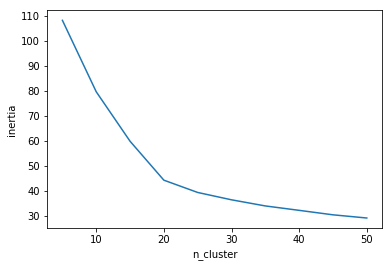

In [132]:
# plot the inertia scores and look for the kink in the curve
plt.plot(n_clusters, inertias)
plt.xlabel('n_cluster')
plt.ylabel('inertia');

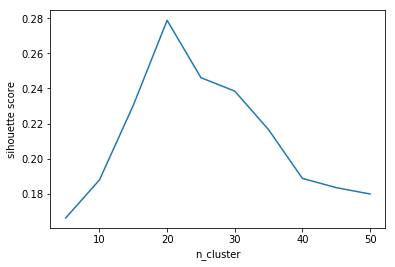

In [133]:
# plot the silhouettte scores
plt.plot(n_clusters, silhouettes)
plt.xlabel('n_cluster')
plt.ylabel('sihouette score');

In [136]:
seed = 129
kmeans = KMeans(n_clusters=20, init="k-means++", random_state=seed)
kmeans.fit(reduced)
labels = kmeans.labels_
print("Inertia score: {}".format(kmeans.inertia_))

silhouette = silhouette_score(reduced, 
                              labels, 
                              metric='euclidean', 
                              sample_size=10000, 
                              random_state=seed)
print("Silhouette score: {}".format(silhouette))

Inertia score: 44.378014384849806
Silhouette score: 0.27540920566324123


### TSNE Dimension Reduction and Visualization

In [137]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=500, random_state=seed)
tsne_reduced = tsne.fit_transform(reduced)

In [139]:
df_tsne_reduced = pd.DataFrame(tsne_reduced, columns=["tsne_x", "tsne_y"])
df_tsne_reduced.shape

(58595, 2)

In [141]:
df_tsne_reduced['Cluster'] = labels
df_tsne_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58595 entries, 0 to 58594
Data columns (total 3 columns):
tsne_x     58595 non-null float32
tsne_y     58595 non-null float32
Cluster    58595 non-null int32
dtypes: float32(2), int32(1)
memory usage: 686.7 KB


In [229]:
groups = df_tsne_reduced.groupby('Cluster')

In [230]:
colors = pd.read_csv('/home/cneiderer/Documents/20distinctcolors.csv', header=None)
cmap = colors.iloc[:, 1]

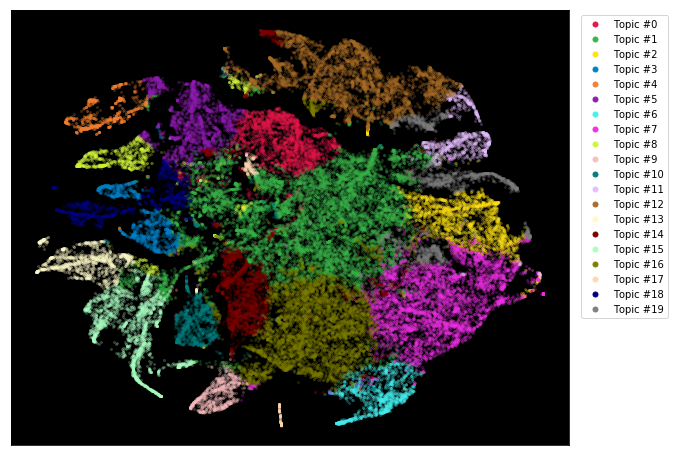

In [238]:
fig, ax = plt.subplots(figsize=(10, 8))
cidx = 0
for name, group in groups:
    ax.plot(group.tsne_x, group.tsne_y, marker='o', linestyle='', ms=2, alpha=0.2, label=name, color=cmap[cidx])
    cidx += 1
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('k')
label_strings = ['Topic #%d' % x for x in set(labels)]
# leg = ax.legend(loc='upper right')
leg = ax.legend(label_strings, loc=9, bbox_to_anchor=(1.1, 1))
for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(1)
    lh._legmarker.set_markersize(5)

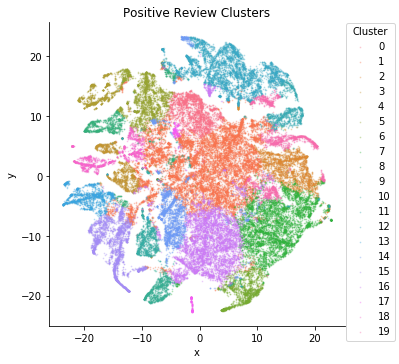

In [174]:
# visualize the positive review clusters using t-SNE
tsne_positive = sns.lmplot("tsne_x", "tsne_y", 
                           data=df_tsne_reduced, 
#                            palette=sns.color_palette('gist_earth', 20),
                           fit_reg=False, 
                           hue="Cluster",
                           scatter_kws={'alpha': 0.3, 's': 0.5})
plt.xlabel("x")
plt.ylabel("y")
plt.title("Positive Review Clusters");